In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [4]:
def split_data(df, split_date=None, start_date=None, end_date=None, with_val=False, val_size=0, test_size=1):
    if with_val:
        df_train = df.iloc[:-(val_size+test_size)]
        df_valid = df.iloc[-(val_size+test_size):-test_size]
        df_test = df.iloc[-test_size:]
        return df_train, df_valid, df_test
    else:
        train = df[df.date <= split_date]
        test = df[df.date > split_date]
        if start_date is not None:
            train = train[train.date >= start_date]
        if end_date is not None:
            test = test[test.date <= end_date]
        return train, test

In [6]:
df_risk = pd.read_csv('df_risk.csv')
df_train_all, df_test_all = split_data(df_risk, split_date='2023-12-02')


#функции

In [10]:
#df_train_all_pca = df_train_all.pct_change().dropna(axis=0)
#df_test_all_pca = df_test_all.pct_change().dropna(axis=0)
#df_risk_pca = df_risk.pct_change().dropna(axis=0)

In [7]:
def Wiener_process(w0, dt, N_traj):
    d = 1
    N_t = len(dt) + 1
    W_s = np.zeros([N_traj, d, N_t])
    W_s[..., 0] = w0
    for kk in np.arange(1, N_t):
        noises = np.random.randn(N_traj, d)
        W_s[...,kk] = W_s[..., kk-1] + np.sqrt(dt[kk-1]) * noises
    return W_s[:,0,:]

def generate_dW_corr(data, dt, w0=0, N_traj=1):
    cholesky_matrix = np.linalg.cholesky(np.corrcoef(data, rowvar=False))
    dW = np.array([np.diff(Wiener_process(w0=w0, dt=dt,N_traj=N_traj)) for _ in range(data.shape[1])])

    dW_corr = dW.copy()

    for i in range(0, N_traj):
        dW_corr[:, i, :] = np.dot(cholesky_matrix, dW[:, i, :])

    return dW_corr  # (n_ft x N_traj x ts_len)

def parametrs_estimation_1(r, dt):
    # замена
    y = np.diff(r)
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

def process_1(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*dt[t-1] + b*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

def parametrs_estimation_2(r, dt):
    # замена
    r_t1 = r[:-1]
    y = np.diff(r) / r_t1
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

def process_2(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*r_t1*dt[t-1] + b*r_t1*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

def parametrs_estimation_CIR(r, dt):
    # замена
    sqrt_r_t1 = np.sqrt(r[:-1])
    y = np.diff(r) / sqrt_r_t1
    x_1 = dt / sqrt_r_t1
    x_2 = dt * sqrt_r_t1
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры: #p1 = ab, p2 = -a
    ab = linreg.coef_[0]
    a = -linreg.coef_[1]
    b = ab / a
    c = np.std(y - y_pred)
    if 2*a*b < c**2:
        #print('Ошибка в параметрах')
        print('Внимание: 2ab < c^2')
    return {'a': a, 'b': b, 'c': c}

def process_CIR(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b, c = param['a'], param['b'], param['c']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*(b - r_t1)*dt[t-1] + c*np.sqrt(np.abs(r_t1))*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

def parametrs_estimation_FX(r, dt):
    # замена
    y = np.diff(r)
    x_1 = dt
    x_2 = dt * r[:-1]
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = -linreg.coef_[1]
    b = linreg.coef_[0] / a
    c = np.std(y - y_pred)
    return {'k': a, 'theta': b, 'sigma': c}

def process_FX(param, r_0, dt, dWt):
    T = len(dt) + 1
    k, th, sigma = param['k'], param['theta'], param['sigma']

    y_sim = [r_0]
    for t in range(1, T):
        y_t1 = y_sim[t-1]
        y_t = y_t1 + k*(th - y_t1)*dt[t-1] + sigma*dWt[t-1]
        y_sim.append(y_t)

    return np.exp(y_sim)

def calculate_metric(y_true, y_sim_N, mode='rmse'):
    res = []
    if mode == 'rmse':
        for y_sim in y_sim_N:
            res.append(mean_squared_error(y_true, y_sim, squared=False))
        return np.mean(res)
    elif mode == 'mae':
        for y_sim in y_sim_N:
            res.append(mean_absolute_error(y_true, y_sim))
        return np.mean(res)
    elif mode == 'mape':
        for y_sim in y_sim_N:
            res.append(mean_absolute_percentage_error(y_true, y_sim))
        return np.mean(res)
    else:
        return None

In [41]:
class Stoch_Models:
    def __init__(self, factor_name,
                 value_train, value_test,
                 t_train, t_test,
                 N_traj=10, dW_N=None, models=None):
        self.name = factor_name
        self.val_train = value_train
        self.val_test = value_test
        self.val_t0 = value_train[0]
        self.val_last = value_train[-1]
        self.t_train = t_train
        self.t_test = t_test
        self.t_array = t_train + t_test
        self.N_traj = N_traj

        # модели
        if models is None:
            self.models = ['m1', 'm2', 'm3', 'm4']
        else:
            self.models = models

        self.models_info = {
            'm1': '$a dt + b dW_t$',
            'm2': '$a X_t dt + b X_t dW_t$',
            'm3': 'CIR',
            'm4': 'FX'
        }

        # приращения винеровского процесса
        self.dW_N = self.Wiener_simulation() if dW_N is None else dW_N

        # параметры
        self.parametrs_func = {
            'm1': parametrs_estimation_1,
            'm2': parametrs_estimation_2,
            'm3': parametrs_estimation_CIR,
            'm4': parametrs_estimation_FX
        }
        self.paramters = {}

        # симуляции
        self.simulations_func = {
            'm1': process_1,
            'm2': process_2,
            'm3': process_CIR,
            'm4': process_FX
        }
        self.simulations = {}

        # метрика
        self.metric = 'rmse'
        self.res_metric = {}

        #для визуализации
        self.colors = {
            'm1': 'goldenrod',
            'm2': 'seagreen',
            'm3': 'steelblue',
            'm4': 'indianred',
            'factor': 'black'
        }

    def Wiener_simulation(self):
        w0=0
        dt_ = np.diff(self.t_array)
        wiener_traj = Wiener_process(w0, dt_, self.N_traj)
        dW_N = np.diff(wiener_traj, axis=1)
        return dW_N

    def find_parametrs(self):
        # для каждой стох. модели по train подбираются коээфициенты
        for m in self.models:
            self.paramters[m] = self.parametrs_func[m](self.val_train, np.diff(self.t_train))

    def make_simulations(self):
        self.find_parametrs()
        ct = len(self.t_train)-1
        for m in self.models:
            r_traj = []
            for dWt in self.dW_N[:, :ct]:
                r_tr = self.simulations_func[m](param=self.paramters[m], r_0=self.val_t0, dt=np.diff(self.t_train), dWt=dWt)
                r_traj.append(np.array(r_tr))
            self.simulations[m] = np.array(r_traj)

    def plot_simulations(self, fig_size=(18, 8)):
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for m in self.models:
            axs.plot(self.t_train, self.simulations[m].T, color=self.colors[m], linewidth=0.5)
            axs.plot(self.t_train, np.mean(self.simulations[m], axis=0), color=self.colors[m], linewidth=2, label=self.models_info[m])
        axs.plot(self.t_train, self.val_train, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.legend()
        axs.set_title(self.name)
        plt.show()

    def print_metric_result(self):
        print(self.metric, '\n')
        for m in self.models:
            print(f'{m}: {round(self.res_metric[m], 4)}')

    def find_best_model(self):
        min_m = min(self.res_metric.values())
        best_model = None
        for m in self.res_metric.keys():
            if self.res_metric[m] == min_m:
                best_model = m
        return best_model

    def plot_simulations_best(self, fig_size=(18, 8)):
        m = self.find_best_model()
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        axs.plot(self.t_train, self.simulations[m].T, color=self.colors[m], linewidth=0.5)
        axs.plot(self.t_train, np.mean(self.simulations[m], axis=0), color=self.colors[m], linewidth=2, label=self.models_info[m])
        axs.plot(self.t_train, self.val_train, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.legend()
        axs.set_title(f'{self.name}, лучшая модель ({self.metric} = {round(self.res_metric[m], 2)})')
        plt.show()

    def choose_model(self, metric=None, print_metric=1, plot_all=1, plot_best=1, fig_size=(18, 8)):
        if metric is not None:
            self.metric = metric

        self.make_simulations()
        for m in self.models:
            self.res_metric[m] = calculate_metric(self.val_train, self.simulations[m], mode=self.metric)

        if print_metric == 1:
            self.print_metric_result()
        if plot_all == 1:
            self.plot_simulations(fig_size)
        if plot_best == 1:
            self.plot_simulations_best(fig_size)

    # моделирование значений на будущее
    def plot_simulations_future(self, r_traj, m, t, fig_size=(20, 5)):
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        axs.plot(self.t_test[:t], self.val_test[:t], color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.plot(self.t_test[:t], r_traj.T, color=self.colors[m], linewidth=0.5)
        axs.legend()
        metr = calculate_metric(self.val_test[:t], r_traj, mode=self.metric)
        axs.set_title(f'{self.name}: моделирование будущих значений ({self.metric} = {round(metr, 2)})')
        plt.show()

    def future_simulation(self, n_steps=None, best_model=None, plot=0):
#         if best_model is None:
#             best_model = self.find_best_model()
        if n_steps is None:
            n_steps = len(self.t_test)
        ct = len(self.t_train)-1
        dt_ = np.diff(self.t_array[ct:ct+n_steps+1])
        dWts = self.dW_N[:, ct:ct+n_steps]
        r_traj = []
        for dWt in dWts:
            r_tr = self.simulations_func[best_model](param=self.paramters[best_model], r_0=self.val_last, dt=dt_, dWt=dWt)
            # Преобразуем в процентное приращение
            r_tr_percentage = (r_tr[1:] / r_tr[:-1] - 1) * 100

            r_traj.append(np.array(r_tr_percentage))
        if plot == 1:
            self.plot_simulations_future(np.array(r_traj), best_model, n_steps)

            #r_traj.append(np.array(r_tr[1:]))
        #if plot == 1:
            #self.plot_simulations_future(np.array(r_traj), best_model, n_steps)
        return np.array(r_traj)

#не функции

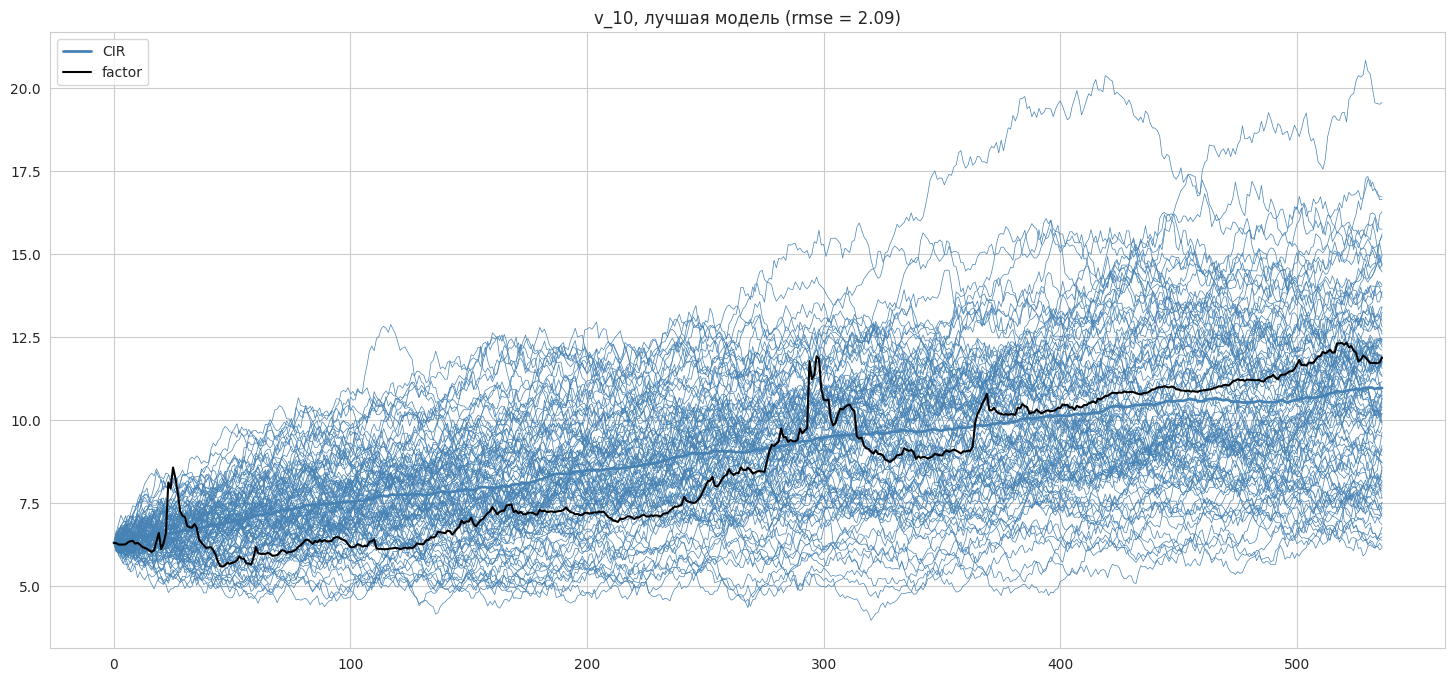

In [9]:
f_col = 'v_10'
sm = Stoch_Models(factor_name=f_col,
                 value_train = df_train_all[f_col].values, value_test = df_test_all[f_col].values,
                 t_train = list(df_train_all.index), t_test = list(df_test_all.index),
                 models=['m1', 'm2', 'm3', 'm4'], N_traj=100)
sm.choose_model(print_metric=0, plot_all=0, metric='rmse')

In [10]:
import copy


class Instrument:
    def __init__(self, name, count, price):
        self.name = name
        self.cnt = count
        self.price = price

    @property
    def cost(self):
        return self.price * self.cnt

    def __repr__(self):
        return "{}({} x {})".format(self.name, self.cnt, self.price)


class Portfolio:
    def __init__(self, tools_with_money, init_prices):
        total = sum(tools_with_money.values())
        self.tools_target = {k: v / total for k, v in tools_with_money.items()}
        self.tools = {
            k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
        }

    @property
    def cost(self):
        return sum([x.cost for x in self.tools.values()])

    def _tool_rate(self):
        total_cost = self.cost
        return {k: v.cost / total_cost for k, v in self.tools.items()}

    def __getitem__(self, k):
        return self.tools[k]

    def rebalancing(self, new_prices):
        old_cost = self.cost
        old_prices = {k: self[k].price for k in self.tools}
        for k, p in new_prices.items():
            self[k].price = p
        new_cost = self.cost
        for k in self.tools:
            self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

        for k, v in self._tool_rate().items():
            assert np.abs(v - self.tools_target[k]) < 0.00001

    def new_cost(self, new_prices):
        new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
        return new_cost

    def copy(self):
        return copy.deepcopy(self)

In [11]:
def semaphore(p):
    if p > 0.05:
        return "green"
    elif p > 0.0001:
        return "yellow"
    else:
        return "red"


def norm_percenile(x, level):
    return np.mean(x) + ss.norm.ppf(level) * np.std(x)

In [14]:
#!pip install optuna
import optuna
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.ERROR)


class Model:
    def __init__(self, n_components=None, pca_args=None, lr_args=None):
        self.pca_args = pca_args or {"random_state": 42}
        self.lr_args = lr_args or {}
        self.n_components = n_components
        self.pca = n_components and PCA(n_components, **self.pca_args)
        self.lr = LinearRegression(**self.lr_args)
        self.cols = None

    def get_values(self, x):
        if self.cols and isinstance(x, pd.DataFrame):
            x = x[self.cols]
        if isinstance(x, (pd.DataFrame, pd.Series)):
            return x.values
        return x

    def fit(self, data, target):
        if isinstance(data, pd.DataFrame):
            self.cols = list(data.columns)
        data = self.get_values(data)
        target = self.get_values(target)
        if self.pca:
            data = self.pca.fit_transform(data)
        self.lr.fit(data, target)
        return self

    def predict_pca(self, data):
        data = self.get_values(data)
        if self.pca:
            return self.pca.transform(data)
        return data

    def predict_lr(self, data):
        return self.lr.predict(data)

    def predict(self, data):
        data = self.predict_pca(data)
        return self.predict_lr(data)

    def __repr__(self):
        return "{}({}, {})".format(self.__class__.__name__, self.pca, self.lr)


class AutoModel:
    def __init__(self, cv_splits=5, n_trials=10, max_components=10, metric=None):
        self.splitter = TimeSeriesSplit(cv_splits)
        self.study = optuna.study.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
        self.metric = metric or r2_score
        self.n_trials = n_trials
        self.max_components = max_components

    def fit(self, data, target):
        data_ = data
        target_ = target
        if isinstance(data, (pd.DataFrame, pd.Series)):
            data = data.values
        if isinstance(target, (pd.DataFrame, pd.Series)):
            target = target.values

        def objective(trial):
            components = trial.suggest_int("n_components", 1, min([self.max_components, *data.shape]))
            for t in trial.study.trials:
                if t.state != optuna.trial.TrialState.COMPLETE:
                    continue
                if t.params == trial.params:
                    raise optuna.exceptions.TrialPruned("Duplicate parameter set")

            scores = []
            for train_idx, test_idx in self.splitter.split(data):
                model = Model(components)
                model.fit(data[train_idx], target[train_idx])
                proba = model.predict(data[test_idx])
                score = self.metric(target[test_idx], proba)
                scores.append(score)
            return np.mean(scores)

        self.study.optimize(objective, self.n_trials)
        return Model(**self.study.best_params).fit(data_, target_)

In [15]:
stonks = df_risk[['GAZP', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'ROSN',
                  'SBER', 'TRNFP', 'YNDX', 'MOEXBC']]

features_tools = df_risk[['GAZP', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'ROSN',
                       'SBER', 'TRNFP', 'YNDX', 'MOEXBC', 'SU26207RMFS9',
                       'SU26207RMFS9', 'SU26212RMFS9', 'SU26224RMFS4', 'SU26225RMFS1',
                       'SU26228RMFS5', 'USD', 'EUR']]

features_risk = df_risk[['v_0_25', 'v_0_5', 'v_0_75', 'v_1', 'v_2', 'v_3',
                       'v_5', 'v_7', 'v_10', 'v_15', 'v_20', 'v_30',
                       "BRENT", 'MOEXBC', 'RTSI']]

In [16]:
results = []
instrument_models = {}

for f in features_tools.columns:
    m = AutoModel().fit(df_train_all[features_risk.columns], df_train_all[f])
    score = m.predict(df_train_all)
    score_test = m.predict(df_test_all)
    results.append(
        {
            "tool": f,
            "n_components": m.n_components,
            "r2_train": r2_score(df_train_all[f], score),
            "r2_test": r2_score(df_test_all[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results

,tool,n_components,r2_train,r2_test
0,GAZP,2,0.718738,-42.084120
1,GMKN,10,0.866949,-17.525271
2,LKOH,1,0.744112,-57.047000
3,MGNT,1,0.299098,-21.086175
4,MTSS,4,0.822535,-15.364313
5,NVTK,6,0.931634,-4.018432
6,ROSN,1,0.782930,-42.256916
7,SBER,10,0.970149,-4.387747
8,TRNFP,2,0.711757,-0.870772
9,YNDX,1,0.751145,-98.796445


In [17]:
init_tools = {
    "GAZP": 1_000_000,
    "GMKN": 1_000_000,
    "LKOH": 1_000_000,
    "MGNT": 1_000_000,
    "MTSS": 1_000_000,
    "NVTK": 1_000_000,
    "ROSN": 1_000_000,
    "SBER": 1_000_000,
    "TRNFP": 1_000_000,
    "YNDX": 1_000_000,
    "SU26207RMFS9": 10_000_000,
    "SU26212RMFS9": 10_000_000,
    "SU26224RMFS4": 10_000_000,
    "SU26225RMFS1": 10_000_000,
    "SU26228RMFS5": 10_000_000,
    "USD": 100_000_000,
    "EUR": 100_000_000,
}

In [18]:
import copy


class Instrument:
    def __init__(self, name, count, price):
        self.name = name
        self.cnt = count
        self.price = price

    @property
    def cost(self):
        return self.price * self.cnt

    def __repr__(self):
        return "{}({} x {})".format(self.name, self.cnt, self.price)


class Portfolio:
    def __init__(self, tools_with_money, init_prices):
        total = sum(tools_with_money.values())
        self.tools_target = {k: v / total for k, v in tools_with_money.items()}
        self.tools = {
            k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
        }

    @property
    def cost(self):
        return sum([x.cost for x in self.tools.values()])

    def _tool_rate(self):
        total_cost = self.cost
        return {k: v.cost / total_cost for k, v in self.tools.items()}

    def __getitem__(self, k):
        return self.tools[k]

    def rebalancing(self, new_prices):
        old_cost = self.cost
        old_prices = {k: self[k].price for k in self.tools}
        for k, p in new_prices.items():
            self[k].price = p
        new_cost = self.cost
        for k in self.tools:
            self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

        for k, v in self._tool_rate().items():
            assert np.abs(v - self.tools_target[k]) < 0.00001

    def new_cost(self, new_prices):
        new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
        return new_cost

    def copy(self):
        return copy.deepcopy(self)


In [30]:
df_risk

,date,MOEXBC,RTSI,USD,EUR,BRENT,v_0_25,v_0_5,v_0_75,v_1,...,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,TRNFP,YNDX
0,2020-01-14,21295.55,1604.96,60.9474,67.8162,64.489998,5.36,5.38,5.41,5.44,...,250.00,20000.0,6520.5,3339.0,317.30,1259.0,475.50,259.05,177700.0,2685.0
1,2020-01-15,21310.72,1602.29,61.4140,68.4213,64.000000,5.41,5.42,5.44,5.46,...,251.30,20396.0,6552.5,3440.0,318.65,1260.0,474.50,256.31,176850.0,2690.0
2,2020-01-16,21500.64,1612.72,61.4328,68.3747,64.620003,5.30,5.33,5.37,5.41,...,254.26,20900.0,6590.0,3625.0,319.80,1264.0,480.95,257.51,178000.0,2719.8
3,2020-01-21,21835.38,1634.32,61.4654,68.2082,64.589996,5.39,5.40,5.42,5.44,...,252.99,21450.0,6708.5,3840.0,328.70,1242.0,486.15,268.06,178400.0,2770.0
4,2020-01-22,21589.08,1612.87,61.8552,68.6222,63.209999,5.36,5.39,5.42,5.45,...,248.10,21310.0,6655.5,3750.0,333.80,1196.8,478.15,266.54,178050.0,2790.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2023-12-20,19762.76,1075.11,90.0870,98.5764,79.699997,14.43,13.37,12.67,12.23,...,163.56,17114.0,6735.0,6692.5,250.00,1531.2,578.60,266.61,143550.0,2288.8
545,2023-12-21,19576.20,1051.87,90.4056,99.0480,79.389999,13.85,12.82,12.35,12.15,...,161.57,17082.0,6702.0,6704.5,248.85,1478.2,577.10,265.19,143250.0,2267.2
546,2023-12-26,19713.18,1063.05,91.9690,101.5781,81.070000,13.22,12.60,12.28,12.13,...,161.00,16360.0,6771.0,6920.5,248.85,1476.2,589.30,271.90,144350.0,2427.6
547,2023-12-27,19735.52,1068.71,91.7069,101.1178,79.650002,12.78,12.72,12.65,12.59,...,159.86,16310.0,6768.0,6982.5,247.65,1450.6,594.55,271.08,144950.0,2550.0


In [42]:
class PortfolioSimulation:
    def __init__(self, init_tools, window_size, t):
        features_tools = sorted(list(init_tools.keys()))
        p = Portfolio(init_tools, df_risk.iloc[0][features_tools].to_dict())
        portfolio_prices = []
        for i, row in tqdm(df_risk.iterrows(), total=len(df_risk)):
            p.rebalancing(row[features_tools].to_dict())
            portfolio_prices.append(
                {
                    "date": i,
                    "price": p.cost,
                }
            )
        self.portfolio_prices = pd.DataFrame(portfolio_prices)
        self.portfolio_prices["price_change"] = self.portfolio_prices["price"].pct_change()

        instrument_simulations = [None] * len(features_tools)
        # Получаем симуляции для не-стоков
        for fi, f in tqdm(enumerate(features_tools), total=len(features_tools)):
            if f in stonks.columns:
                continue
            m = instrument_models[f]
            pca_df = m.predict_pca(df_risk_restricted)
            simulations = []
            for i in range(len(pca_df) - window_size - t):
                pca_sim = Stoch_Models.future_simulation(pca_df[i : i + window_size], t)
                simulations.append(m.predict_lr(pca_sim))
            instrument_simulations[fi] = simulations
        # Получаем симуляции для стоков
        if any([x is None for x in instrument_simulations]):
            stock_df = df_risk_restricted[[f for f in features_tools if f in stonks.columns]].values
            simulations = []
            for i in range(len(stock_df) - window_size - t):
                stock_sim = Stoch_Models.future_simulation(stock_df[i : i + window_size], t)
                simulations.append(stock_sim)
            simulations = np.array(simulations)
            stock_i = 0
            for fi, f in enumerate(features_tools):
                if f in stonks.columns:
                    instrument_simulations[fi] = simulations[:, :, stock_i]
                    stock_i += 1

        assert all([x is not None for x in instrument_simulations])
        instrument_simulations = np.array(instrument_simulations)

        portfolio_prices_simulations = []
        df_ = df_risk.iloc[window_size + t + 1 :].copy()
        p = Portfolio(init_tools, df_.iloc[0].to_dict())
        for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
            p.rebalancing(row[features_tools])
            p_sim = []
            p_init = p.cost
            # симуляции по всем инструментам за конкретный день
            new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
            new_prices = row[features_tools].values + new_prices
            for sim in new_prices:
                p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
            portfolio_prices_simulations.append(
                {
                    "date": i,
                    "price_change": p_sim,
                }
            )

        self.portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

        self.portfolio_prices_simulations["var_99"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -norm_percenile(x, 0.01)
        )

        self.portfolio_prices_simulations["es_97,5"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -(np.array(x)[np.array(x) < norm_percenile(x, 0.025)]).mean()
        )

        self.returns = (
            self.portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"].reset_index(drop=True)
        )

    def plot_dynamics(self):
        self.portfolio_prices.plot(x="date", y="price", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика стоимости портфеля")
        plt.show()

        self.portfolio_prices.dropna(axis=0).plot(x="date", y="price_change", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика изменений стоимости портфеля")
        plt.show()

    def calc_test(self, risk, risk_name, risk_color="r*", alpha=0.99):
        hits = self.returns < self.portfolio_prices_simulations[risk]
        hit_times = hits.index[hits]
        print("Риск-фактор:", risk_name)
        print("Кол-во пробоев:", hits.sum())
        print("Доля пробоев:", np.round(hits.sum() / hits.size, 4))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="two-sided")
        print("Двухсторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="greater")
        print("Односторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        plt.figure(figsize=(15, 4), facecolor="w")
        idx = self.portfolio_prices_simulations["date"]
        plt.plot(idx, self.returns)
        plt.plot(idx, self.portfolio_prices_simulations[risk], c="r", alpha=0.4, label=risk_name)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
        plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label="train-test split")
        plt.plot(idx[hit_times], self.returns[hit_times], risk_color)
        plt.title("Динамика изменений стоимости портфеля, {}".format(risk_name))
        plt.ylabel("Процентное изменение")
        plt.grid()
        plt.legend()
        plt.show()

In [39]:
df_risk.set_index('date', inplace=True)
df_risk_restricted = df_risk.iloc[1:]

KeyError: "None of ['date'] are in the columns"

In [43]:
ps = PortfolioSimulation(init_tools, 60, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 't_train'